# Analise exploratoria de dados

Vamos começar explorando nossos dados, em busca de qualquer pré processamento necessário.


IDEIA: PARA LOCAL, CAATEGORIZAR POR BAIRRO E VER O PREÇO MEDIO DE COMPRA PRO BAIRRO NA INTERNET, DAI CALCULAR ALGUM RETORNO DE INVESTIMENTO EM PRAZO


In [2]:
## Adicionando todos pre requisitos e pacotes

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from Levenshtein import distance
from matplotlib.cm import get_cmap

In [3]:
## Funções auxiliares

# Definimos a função para transformar em log os valores
def log_transform(data,col):
    for colname in col:
        ## Para aplicar log temos que verificar que não há valores zero, já fizemos isso para preço mas para outras variáveis pode gerar problema
        if (data[colname] <= 0).any():
            data[colname + '_log'] = np.log(data[colname] + 1)
        else:
            data[colname + '_log'] = np.log(data[colname])

# Plot de histograma
def print_hist(df,col):
    print(col)
    print('Skew :', round(df[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    df[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.show()

In [4]:
## Construindo o dataframe que vamos usar

df = pd.read_csv('teste_indicium_precificacao.csv')

Vamos conferir como se parece nossa base de dados  

In [5]:
df.head(3)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194


Aqui vamos conferir primeiro se os valores tem algum problema com preenchimento, sem filtrar tanto os dados. Começamos verificando quantos valores null nos temos.

In [6]:
df.isnull().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

No caso do nome do local e do host, como podem ser variaveis de interesse, e não há uma forma natural de preencher esses dados vamos filtrar as entradas nulas.


Para o caso da ultima_review e reviews_por_mes, verificamos se isso é devido ao fato do local não possuir avaliações.


In [7]:
## Limpa as entrada nulas nos nomes

df = df.dropna(subset=["nome", "host_name"])

## Verifica se algum caso com null nao foi preenchido incorretamente

df[(df["ultima_review"].isnull()) & (df["numero_de_reviews"] == 0)].size == df[df["ultima_review"].isnull()].size and df[(df["reviews_por_mes"].isnull()) 
                                                                                                                         
                                                                                                                         
& (df["numero_de_reviews"] == 0)].size == df[df["reviews_por_mes"].isnull()].size

True

Portanto, levamos em consideração isso no momento de utilizar esses dados, e em como preencher no momento de fazer a análise.

QUANDO EU SOUBER POSSO PREENCHER AQUI


Aqui vamos começar a analisar a presença de outliers, uma forma padrão de identificar outliers é atraves da regra de 1,5 IQR (Intervalo interquartil), onde IQR é dado pela diferença entre o primeiro e o terceiro quartil.

Porém não iremos filtrar todos os outliers, pois 


PENSANDO NO CASO DO PREÇO É BOM CONFERIR ANTES AS OUTRAS CARACTERISTISCAS ANTES DE FILTRAR, VER TODOS FORA DO IQR E SE FOREM MUITOS CORTAR, SE NAO AVALIAR SE A CASA E MT GRANDE OU ALGO ASSIM. 

PREÇO MINIMO 0 é ESTRANHO

Como para preço MEDIA -1.5IQR = -7 <0, consideramos uma faixa inferior razoavel, como por exemplo 9 por noite (não existem dados com price entre 1 e 9).




Aqui vamos começar a analisar os dados de fato, buscamos primeiro olhar como se apresentam as distribuições em cada variavel numérica. As variaveis de id são desconsideradas nesse momento 


In [8]:
df.drop(columns=['id', 'host_id']).describe().drop('count')

,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
mean,40.728943,-73.95217,152.740385,7.012567,23.273390,1.373259,7.148392,112.796263
std,0.054527,0.04616,240.234843,20.019944,44.550307,1.680339,32.964937,131.607363
min,40.499790,-74.24442,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690090,-73.98307,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.95568,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763110,-73.93628,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.71299,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


## Primeira analise

Algumas coisas chamam nossa atenção nesse momento. Vamos listar algumas:

- A variavel preço apresenta alguns pontos
    - Preço minimo igual a 0, o que soa estranho para o aluguel de um local
    - Máximo muito discrepante do restante dos valores, porém como isso pode representar locais de alto padrão vamos optar por transformações nos dados ao inves de um corte de outliers direto.
    - Variação muito alta.
- A variavel minimo de noite tem um valor de maximo que também parece estranho parecendo ser outlier e não retratando o tipo de dado que queremos analisar.
- O primeiro quartil da disponibilidade é 0, precisamos olhar o que isso representa, vamos assumir aqui que são locais que estão com listagens antigas e não estão sendo locados mais, dessa forma é provavel que retiremos da analise boa parte desses locais.



Vamos tratar caso a caso. Para a variavel preço, notamos que 10 é o proximo valor minimo após 0, portanto vamos filtrar todos dados com preço menor que 10.

In [9]:
## Verificando que de 0 a 9 não há valores.
print(max(df[df['price'] <= 9]['price']) )

## Atualizando os dados
df = df[df['price'] > 9]


0


Agora verificamos como fica a distibuição de preços e vemos que o grafico está com skew muito alto, para tentar amenizar vamos aplicar uma transformação tipo log.

price
Skew : 19.11


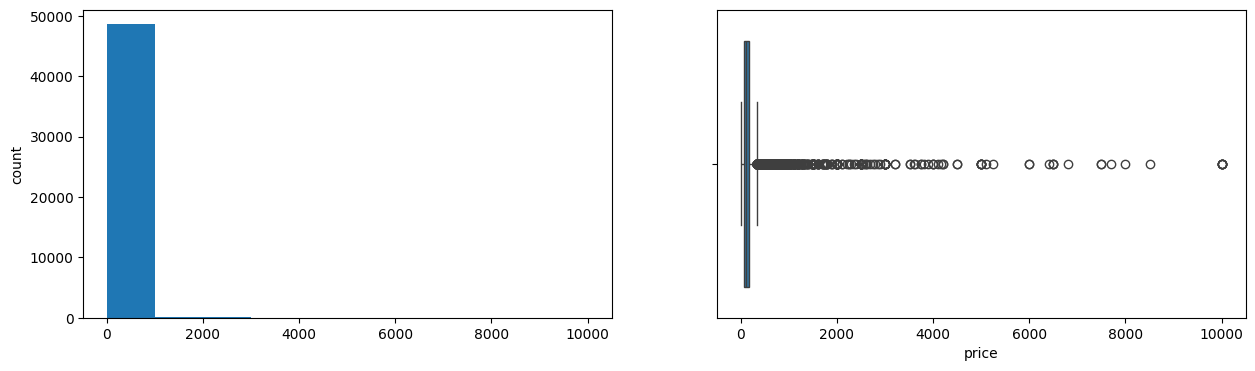

In [10]:

# Verificando a distribuição de preço
print_hist(df,'price')

In [11]:
# Transformamos e verificamos agora a distribuição
log_transform(df,['price'])

price_log
Skew : 0.61


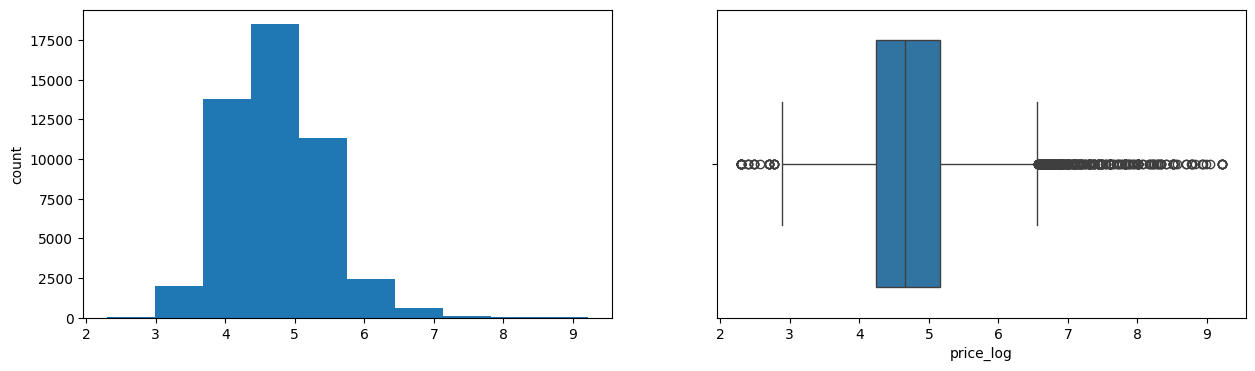

In [12]:
# Verificando a distribuição de log preço
print_hist(df,'price_log')

Agora a distribuição de preço parece mais normalizada.

Vamos prosseguir com a remoção de outliers, porém para uma perspectiva de negócios é interessante manter os dados com os preços mais altos, portanto vamos criar uma pequena base de dados separados apenas com os dados cortados aqui.

In [13]:
## Calculamos os quartis e o IQR

Q1_p = df['price_log'].quantile(0.25)
Q3_p = df['price_log'].quantile(0.75)
IQR_p = Q3_p - Q1_p

## Definimos os valores de treshold
[liminf_p,limsup_p] = [Q1_p - 1.5 * IQR_p,Q3_p + 1.5 * IQR_p]


## Geramos um df para casas de alto padrao e filtramos o atual

df_hp = df[df['price_log'] > limsup_p]

df = df[(df['price_log'] >= liminf_p) & (df['price_log'] <=  limsup_p)]





Prosseguimos agora para analisar o minimo de noites de hospedagem. Primeiro vemos a distribuição dos dados

minimo_noites
Skew : 21.59


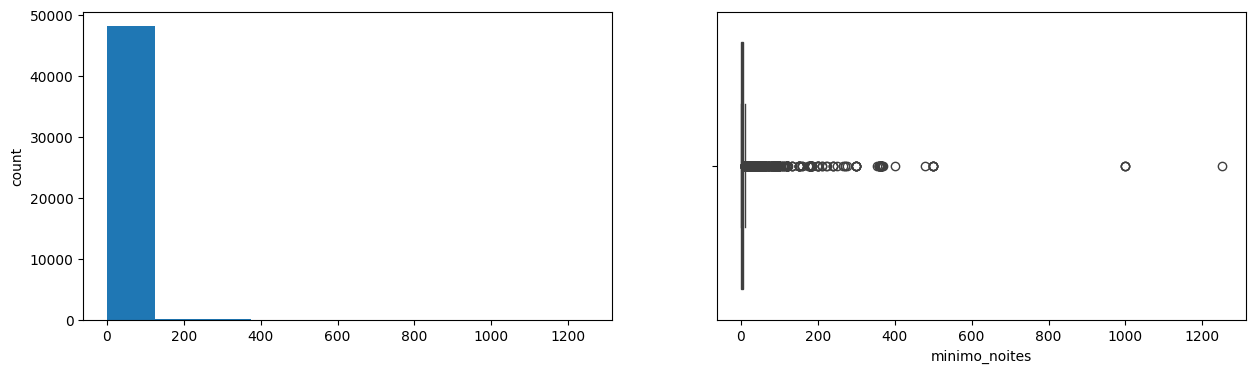

Minimo do minimo de noites:  1.00


In [14]:
print_hist(df,'minimo_noites')
print(f"Minimo do minimo de noites:  {min(df['minimo_noites']):.2f}")

O grafico também tem um skew muito alto, portanto aplicaremos a mesma ideia de transformar em log.

minimo_noites_log
Skew : 1.11


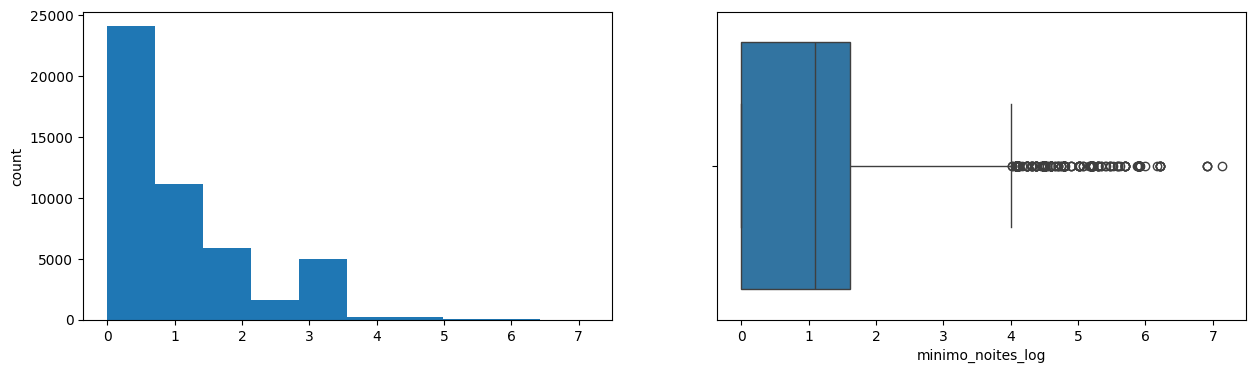

In [15]:
## Transformando o dado em log
log_transform(df,['minimo_noites'])
print_hist(df,'minimo_noites_log')

In [16]:
## Analisando a presença de outliers

Q1_mn = df['minimo_noites_log'].quantile(0.25)
Q3_mn = df['minimo_noites_log'].quantile(0.75)
IQR_mn = Q3_mn - Q1_mn

## Definimos os valores de treshold
[liminf_mn,limsup_mn] = [Q1_mn - 1.5 * IQR_mn,Q3_mn + 1.5 * IQR_mn]
print(f"Limite Inferior:  {liminf_mn:.2f}")
print(f"Limite Superior:  {limsup_mn:.2f}")



Limite Inferior:  -2.41
Limite Superior:  4.02


Então nesse caso, como não há valores de noites menor que 1 (ou 0 em log), consideramos que não há corte inferior, apenas superior que são para estadias de longo prazo. Como nosso negocio esta centrado em estadias temporarias, nao vamos nos ater aos dados com um minimo de noites muito alto.


In [17]:
df = df[(df['minimo_noites_log'] >= liminf_mn) & (df['minimo_noites_log'] <=  limsup_mn)]

Voltamos nossa atenção agora ao ponto da disponibilidade ao longo do ano. Repare como a distribuição apresenta um comportamento diferente

disponibilidade_365
Skew : 0.78


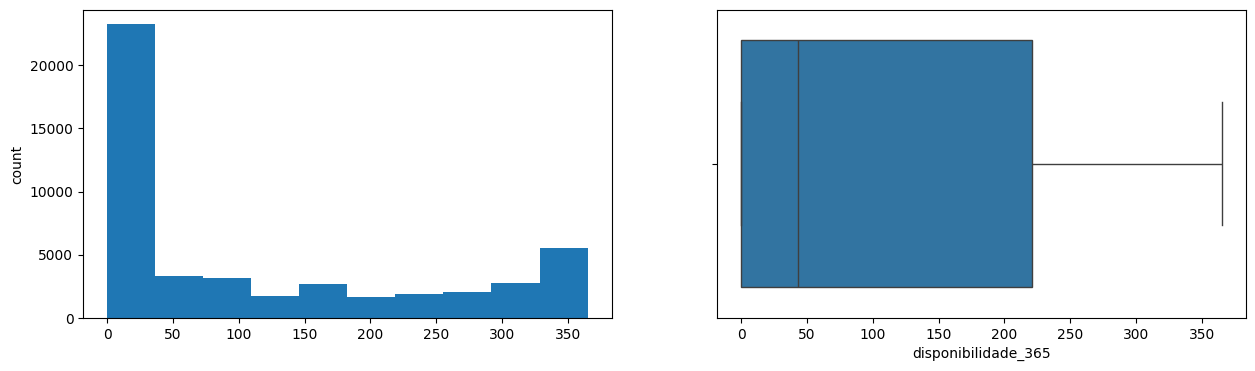

In [18]:
print_hist(df,'disponibilidade_365')

Uma possibilidade de pensar nesses dados no contexto que estamos analisando é de que alguns dos locais sem disponibilidade não estão disponiveis ainda para serem locados, outros porém estão constantemente com reservas.

Vamos aplicar um filtro de locais sem disponibilidade e sem avaliações, focando em eliminar o primeiro grupo de locais. 

Note que há uma grande porcentagem de locais sem disponibilidade, mais de 20.000 destes.



In [19]:
## Conferir quantos elementos serão apagados pelo filtro
len(df[(df['disponibilidade_365']==0) & df['ultima_review'].isnull()])

4692

Portanto estamos eliminando apenas uma parte, a depender de uma analise posterior com o cliente seria interessante levantar o ponto de se querer manter ou não esses dados restantes.

In [20]:
## Filtrar os dados

df = df[~((df['disponibilidade_365'] == 0) & df['ultima_review'].isna())]

Vamos julgar o que se caracterizaria como outlier nesse caso pelo nosso padrão.


disponibilidade_365
Skew : 0.63


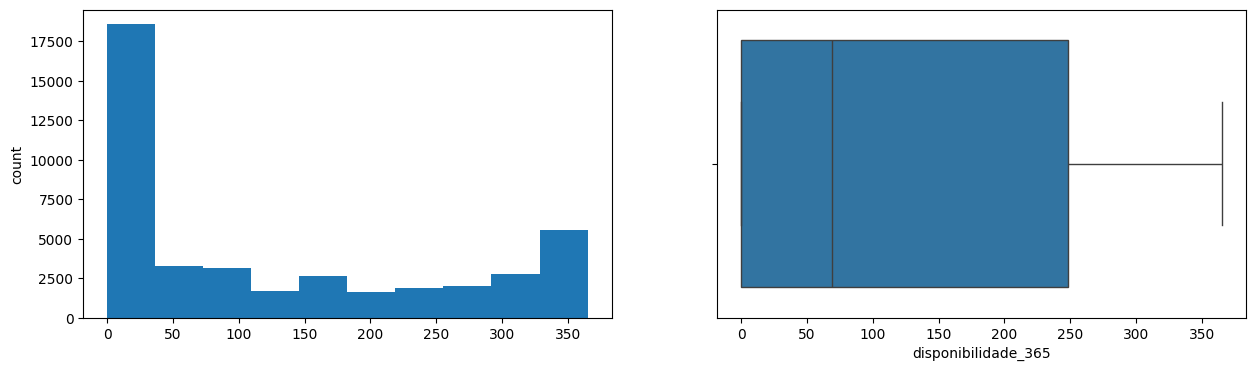

In [21]:
print_hist(df,'disponibilidade_365')

Nesse caso temos um comportamento tipo binormal, e o metodo IQR não seria tão efetivo para remoção de outliers. Considerando os casos que já removemos, vamos manter o restante dos dados, porém seria interessante alguma analise estatistica mais aprofundada se os resultados não forem satisfatorios.

reviews_por_mes
Skew : 3.13


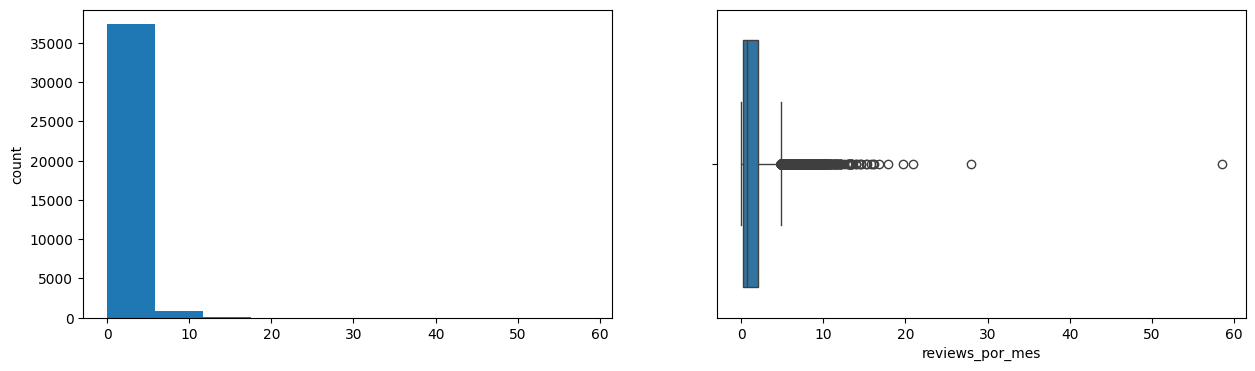

In [22]:
print_hist(df,'reviews_por_mes')

Nesse caso temos um Skew elevado, porém na escala log não há a presença de outliers (SE FOR DEIXAR COLOCO O CODIGO), sendo assim vamos manter todos os dados.

Finalmente para os valores faltantes, para o ultimo review vamos considerar uma data anterior a menor presente nos dados

In [23]:
data_inicial = pd.to_datetime(min(df['ultima_review'].dropna()))

data_i = (data_inicial - pd.DateOffset(years=1)).strftime('%Y-%m-%d')

df['ultima_review'] = df['ultima_review'].fillna(data_i)

E para o reviews por mes, consideramos o valor 0
    

In [24]:
df['reviews_por_mes'] = df['reviews_por_mes'].fillna(0)

## Variaveis textuais


Para as variaveis textuais a verificação de outliers é um pouco mais complexa. Nesse sentido vamos buscar se há a presença de typos ou similares nas entradas.

Começamos vendo as entradas unicas para cada parametro

In [25]:
df.nunique()

id                               43105
nome                             42339
host_id                          32421
host_name                        10465
bairro_group                         5
bairro                             218
latitude                         18245
longitude                        14312
room_type                            3
price                              506
minimo_noites                       44
numero_de_reviews                  394
ultima_review                     1755
reviews_por_mes                    938
calculado_host_listings_count       47
disponibilidade_365                366
price_log                          506
minimo_noites_log                   44
dtype: int64

Como a variavel com mais entradas é bairros, vamos analisar se há a presença de typos. Usaremos a distancia de Levenshtein, que é um algoritmo que busca palavras escritas de forma proxima.

In [26]:
unique_entries = df['bairro'].unique()

# Calcular distancia de Levenshtein
threshold = 2  
possible_typos = []

## Loop nas unicas
for i in range(len(unique_entries)):
    for j in range(i + 1, len(unique_entries)):
        word1, word2 = unique_entries[i], unique_entries[j]
        dist = distance(word1, word2)
        if dist <= threshold: 
            possible_typos.append((word1, word2, dist))
# Para visualização mais simples, usamos um dataframe
typos_df = pd.DataFrame(possible_typos, columns=['Word1', 'Word2', 'Levenshtein Distance'])

# Potencial typos
print(typos_df)

             Word1            Word2  Levenshtein Distance
0  Upper West Side  Upper East Side                     2
1     East Village     West Village                     2
2             SoHo             NoHo                     1


Como parece tudo ok, seguimos para a analise sem fazer alterações nos dados
.


## Correlaçao das variaveis

Começamos agora a analisar relações entre as variaveis.



### Locais para compra/locação

Primeiro nos perguntamos como fica a precificação por bairro nos dados.

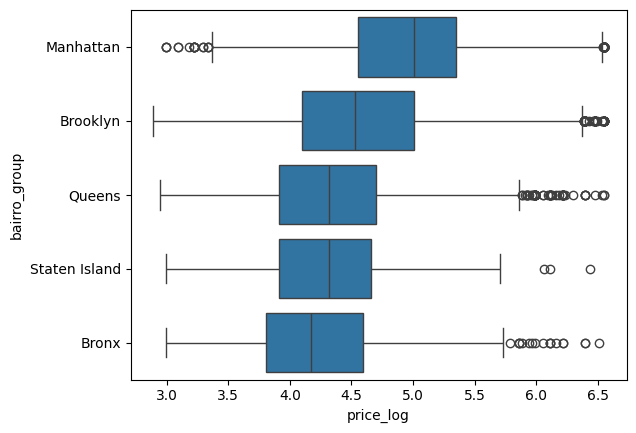

In [34]:
## Vamos analisar a tendencia de preços por cada bairro_group
sns.boxplot( x="price_log", y='bairro_group', data=df, )
plt.show()

Isso indica que há uma tendencia clara nos preços apra Manhattan e Brooklyn. Poderiamos analisar o preço por m^2 em cada bairro e analisar um ROI para cada região, ajudando a nortear a questão de qual região seria melhor para compra. Claro isso é uma pesquisa prévia, que deveria ser melhor localizada com oportunidades e opções disponiveis no momento de compra.

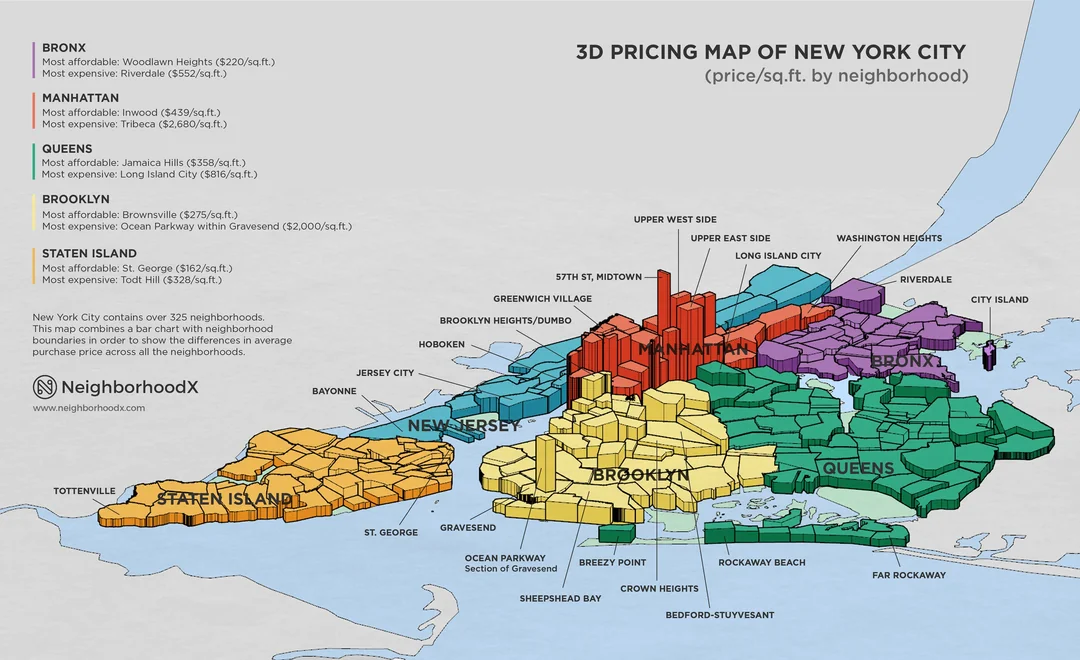  

A imagem apresenta uma tendencia que segue o preço que vemos, para uma análise mais simplista, vamos considerar o preço médio por bairro.



In [ ]:
avg_price = {
    "Bronx": (220 + 552) / 2,  
    "Manhattan": (439 + 2680) / 2,  
    "Queens": (358 + 816) / 2,  
    "Brooklyn": (275 + 2000) / 2,  
    "Staten Island": (162 + 328) / 2  
}

Agora vamos calcular o ROI médio por região usando nossos dados.

In [ ]:
# Calcular o valor médio de locação por região.
avg_rent = df.groupby("bairro_group")["price"].mean()

# Calcular o ROI
roi_bairro = {}
for bairro in avg_rent.index:
    avg_price_sqft = avg_price.get(bairro, None)
    # Checagem se a região está presente
    if avg_price_sqft:  
        annual_rent = avg_rent[bairro] * 12  # Convert to annual rent
        roi_bairro[bairro] = annual_rent / avg_price_sqft  # ROI calculation

# Estruturar como dataframe
roi_df = pd.DataFrame(roi_bairro.items(), columns=["Bairro", "ROI"]).sort_values(by="ROI", ascending=True)


Podemos visualizar como ficaram nossos dados.

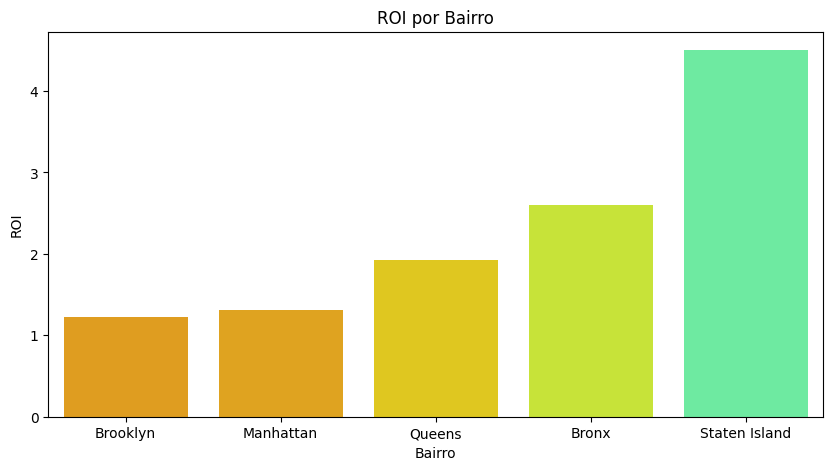

In [ ]:

# Escolha da escala de cores
cmap = plt.colormaps["jet_r"]
norm = plt.Normalize(vmin=-2, vmax=10)

# Atribuindo a cor para cada valor dos dados
colors = [cmap(norm(value)) for value in roi_df["ROI"]]

# Plotando o grafico de barras
plt.figure(figsize=(10, 5))
sns.barplot(y="ROI", x="Bairro", data=roi_df, hue="Bairro", palette=colors, legend=False)
plt.ylabel("ROI")
plt.xlabel("Bairro")
plt.title("ROI por Bairro")

plt.show()

Portanto em média, a região de staten island tem um retorno maior, apesar do seu aluguel ser menor. Claro que para uma análise mais precisa deveriamos comparar por bairro e não por bairro_group, porém isso requer uma coleta de dados mais detalhada por regiões.

### Relação preço e demais parametros

Buscamos agora analisar a relação do preço com nossas variaveis numericas.

Vamos começar a analise explorando um mapa de calor da correlação entre os parametros.

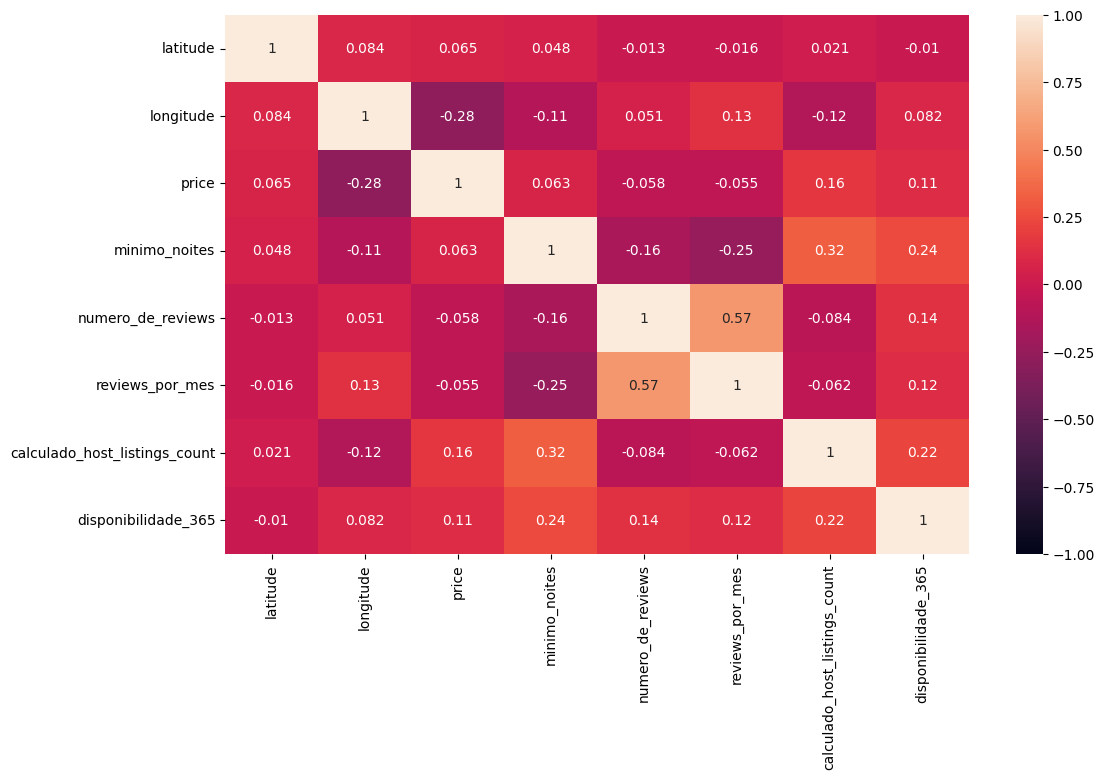

In [65]:

# Separar os parametros em categoricos e numericos
cat_cols=df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(include=np.number).columns.tolist()
# print(f"Categorical Variables: {cat_cols}")
# print(f"Numerical Variables: {num_cols}")


# Adicionando as colunas específicas além das categóricas
exclude_cols = cat_cols + ['price_log', 'minimo_noites_log', 'id', 'host_id']#['price', 'minimo_noites', 'id', 'host_id']


# Plotando um heatmap de correlação
plt.figure(figsize=(12, 7))
sns.heatmap(df.drop(exclude_cols,axis=1).corr(), annot = True, vmin = -1, vmax = 1)
plt.show()

Portanto a variavel que apresenta maior correlação com o preço é a longitude, que faz sentido com o mapa de preço visto anteriormente. 

Vemos também uma leve correlação com a listing_count e a disponibilidade_365. Vamos olhar mais próximo a relação entre preço e disponibilidade.

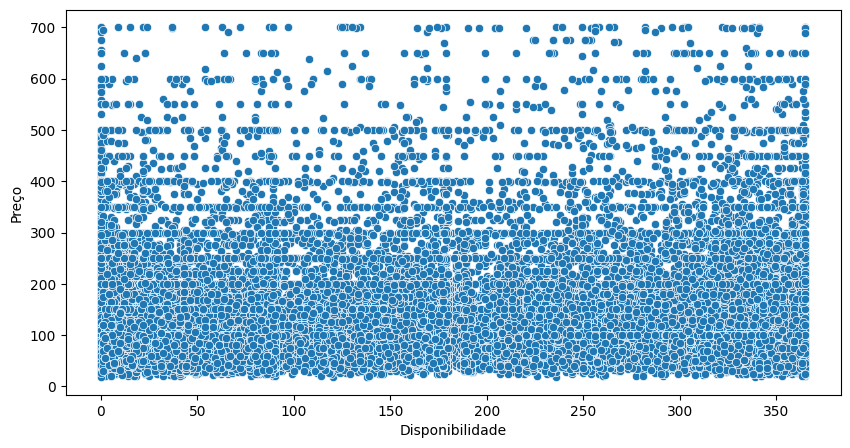

In [62]:
# Plotando o grafico de barras
plt.figure(figsize=(10, 5))
sns.scatterplot(y=df['price'], x=df['disponibilidade_365']);
plt.ylabel("Preço")
plt.xlabel("Disponibilidade");

De fato não há uma relação clara a partir dos dados obtidos.

Tornamos nossa atenção a outra varíavel, ao minimo de noites para se alugar um local.

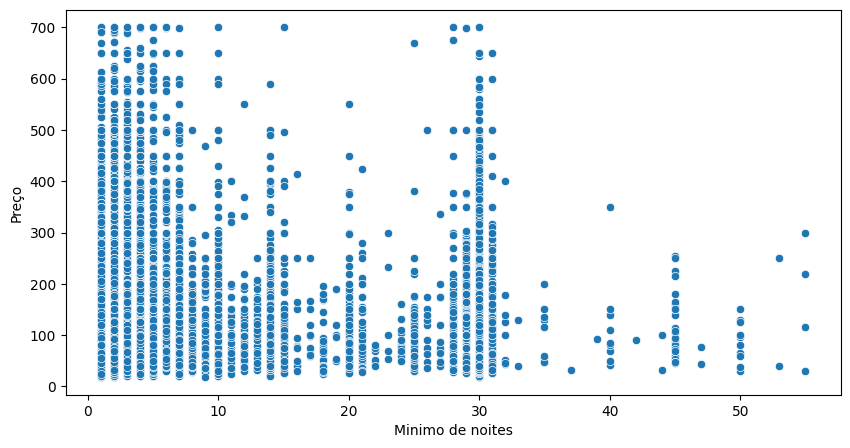

In [67]:
# Plotando o grafico de barras
plt.figure(figsize=(10, 5))
sns.scatterplot(y=df['price'], x=df['minimo_noites'])
plt.ylabel("Preço")
plt.xlabel("Minimo de noites");

Note que por mais que não haja uma correlação clara, vemos que há uma tendencia de locais com um numero maior de minimo de noites estarem limitados a uma faixa de valor relativamente inferior.

Para o caso geral, podemos olhar o pairplot de nossa varíaveis.

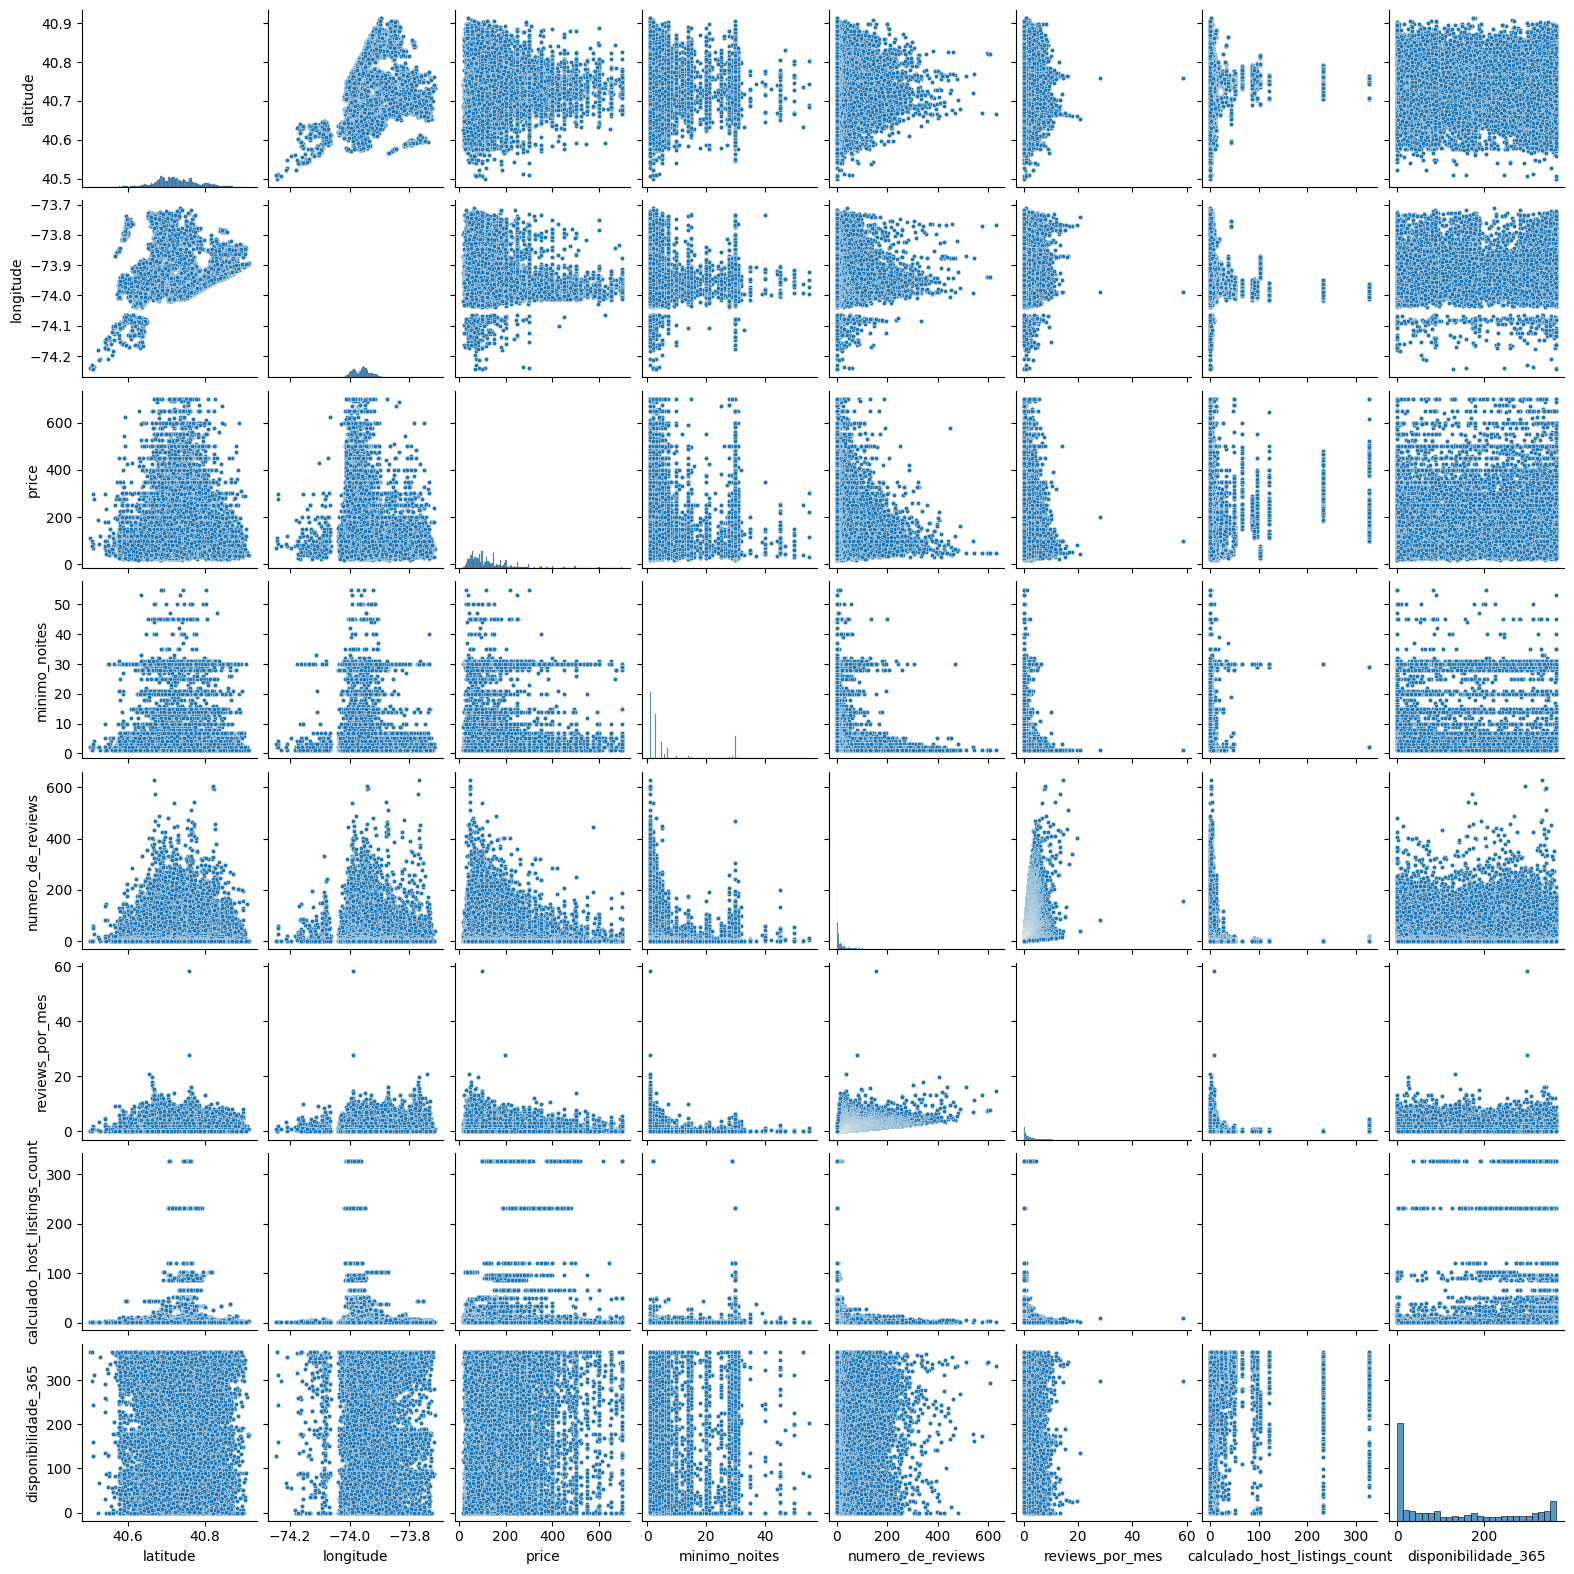

In [70]:
sns.pairplot(data = df.drop(['price_log','minimo_noites_log','id','host_id'],axis = 1), height=2, plot_kws={'s': 10});

Podemos ver que nenhum dos parametros fornecidos por sí so demonstra uma correlação muito alta. 

# Explorando os dados textuais

Agora vamos explorar a relação entre os nomes de locais com valores mais altos. 

Vamos analisar isso de duas formas. Para os dados considerados como outliers por terem valor muito alto e também para o ultimo quartil dos dados que estamos utilizando de fato.